In [1]:
import os
import json
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Seaborn aesthetics
sns.set(style="whitegrid")

In [2]:
def read_json_files(directory: str) -> List[Dict]:
    """
    Reads all JSON files from the specified directory and returns a list of JSON objects.

    Args:
        directory (str): Path to the directory containing JSON files.

    Returns:
        List[Dict]: List of JSON objects.
    """
    json_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as file:
                    data = json.load(file)
                    json_data.append(data)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {filename}: {e}")
            except Exception as e:
                print(f"Error reading file {filename}: {e}")
    return json_data

In [3]:
def emu_to_inches(emu: int) -> float:
    """
    Converts EMU to inches.

    Args:
        emu (int): Value in EMU.

    Returns:
        float: Value in inches.
    """
    return emu / 914400  # 1 inch = 914400 EMU


In [4]:
def aggregate_data(json_data: List[Dict]) -> (pd.DataFrame, pd.DataFrame):
    """
    Aggregates JSON data into slides and shapes DataFrames.

    Args:
        json_data (List[Dict]): List of JSON objects representing presentations.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: DataFrames for slides and shapes.
    """
    slides_records = []
    shapes_records = []
    presentation_id = 1  # Assign a unique ID to each presentation

    for presentation in json_data:
        slide_width = emu_to_inches(presentation.get("slide_width", 0))
        slide_height = emu_to_inches(presentation.get("slide_height", 0))
        for slide in presentation.get("slides", []):
            slide_id = slide.get("slide_id")
            slide_name = slide.get("slide_name", "")
            slides_records.append({
                "presentation_id": presentation_id,
                "slide_id": slide_id,
                "slide_name": slide_name,
                "slide_width_in": slide_width,
                "slide_height_in": slide_height
            })
            for shape in slide.get("shapes", []):
                shape_record = {
                    "presentation_id": presentation_id,
                    "slide_id": slide_id,
                    "shape_id": shape.get("shape_id"),
                    "shape_name": shape.get("name", ""),
                    "shape_type": shape.get("shape_type", ""),
                    "measurement_unit": shape.get("measurement_unit", ""),
                    "height_in": emu_to_inches(shape.get("height", 0)),
                    "width_in": emu_to_inches(shape.get("width", 0)),
                    "left_in": emu_to_inches(shape.get("left", 0)),
                    "top_in": emu_to_inches(shape.get("top", 0)),
                    "text": shape.get("text", ""),
                }

                # Handle font details
                font_details = shape.get("font_details", [])
                for font in font_details:
                    font_record = shape_record.copy()
                    font_record.update({
                        "paragraph_index": font.get("paragraph_index"),
                        "run_index": font.get("run_index"),
                        "font_text": font.get("text", ""),
                        "font_name": font.get("font_name", ""),
                        "font_size_pt": font.get("font_size", 0)
                    })
                    shapes_records.append(font_record)

                # Handle auto_shape_type if present
                if "auto_shape_type" in shape:
                    shape_record["auto_shape_type"] = shape.get("auto_shape_type")
                else:
                    shape_record["auto_shape_type"] = None

                shapes_records.append(shape_record)
        presentation_id += 1

    slides_df = pd.DataFrame(slides_records)
    shapes_df = pd.DataFrame(shapes_records)

    return slides_df, shapes_df


In [5]:
def plot_shape_types_distribution(shapes_df: pd.DataFrame):
    """
    Plots the distribution of shape types.

    Args:
        shapes_df (pd.DataFrame): DataFrame containing shapes data.
    """
    shape_counts = shapes_df['shape_type'].value_counts().reset_index()
    shape_counts.columns = ['shape_type', 'count']

    plt.figure(figsize=(10,6))
    sns.barplot(data=shape_counts, x='shape_type', y='count', palette='viridis')
    plt.title('Distribution of Shape Types')
    plt.xlabel('Shape Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [6]:
def plot_shapes_per_slide(shapes_df: pd.DataFrame):
    """
    Plots the number of shapes per slide.

    Args:
        shapes_df (pd.DataFrame): DataFrame containing shapes data.
    """
    shapes_per_slide = shapes_df.groupby(['presentation_id', 'slide_id']).size().reset_index(name='shape_count')

    plt.figure(figsize=(12,6))
    sns.histplot(shapes_per_slide['shape_count'], bins=range(0, shapes_per_slide['shape_count'].max()+2), kde=False, color='skyblue')
    plt.title('Number of Shapes per Slide')
    plt.xlabel('Number of Shapes')
    plt.ylabel('Number of Slides')
    plt.tight_layout()
    plt.show()


In [7]:
def plot_shapes_by_slide_number(shapes_df: pd.DataFrame):
    """
    Plots the number of shapes against slide numbers across all presentations.

    Args:
        shapes_df (pd.DataFrame): DataFrame containing shapes data.
    """
    # Assign a sequential slide number within each presentation
    shapes_df['slide_number'] = shapes_df.groupby('presentation_id')['slide_id'].rank(method='dense').astype(int)

    shapes_by_slide = shapes_df.groupby('slide_number').size().reset_index(name='shape_count')

    plt.figure(figsize=(12,6))
    sns.lineplot(data=shapes_by_slide, x='slide_number', y='shape_count', marker='o')
    plt.title('Number of Shapes by Slide Number')
    plt.xlabel('Slide Number')
    plt.ylabel('Number of Shapes')
    plt.tight_layout()
    plt.show()


In [8]:
def plot_shape_size_distribution(shapes_df: pd.DataFrame):
    """
    Plots the distribution of shape heights and widths.

    Args:
        shapes_df (pd.DataFrame): DataFrame containing shapes data.
    """
    plt.figure(figsize=(14,6))

    # Height Distribution
    plt.subplot(1, 2, 1)
    sns.histplot(shapes_df['height_in'], bins=30, kde=True, color='salmon')
    plt.title('Distribution of Shape Heights (inches)')
    plt.xlabel('Height (in)')
    plt.ylabel('Count')

    # Width Distribution
    plt.subplot(1, 2, 2)
    sns.histplot(shapes_df['width_in'], bins=30, kde=True, color='skyblue')
    plt.title('Distribution of Shape Widths (inches)')
    plt.xlabel('Width (in)')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


In [9]:
def plot_font_size_distribution(shapes_df: pd.DataFrame):
    """
    Plots the distribution of font sizes.

    Args:
        shapes_df (pd.DataFrame): DataFrame containing shapes data.
    """
    font_sizes = shapes_df['font_size_pt'].dropna()

    plt.figure(figsize=(10,6))
    sns.histplot(font_sizes, bins=20, kde=True, color='purple')
    plt.title('Distribution of Font Sizes (points)')
    plt.xlabel('Font Size (pt)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


Reading JSON files...
Aggregating data...
Total Presentations: 958
Total Slides: 22899
Total Shapes: 336722
Plotting Shape Types Distribution...


/var/folders/_0/9lcpl6ds451bxrqdll83hcbc0000gn/T/ipykernel_65056/2629461836.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=shape_counts, x='shape_type', y='count', palette='viridis')


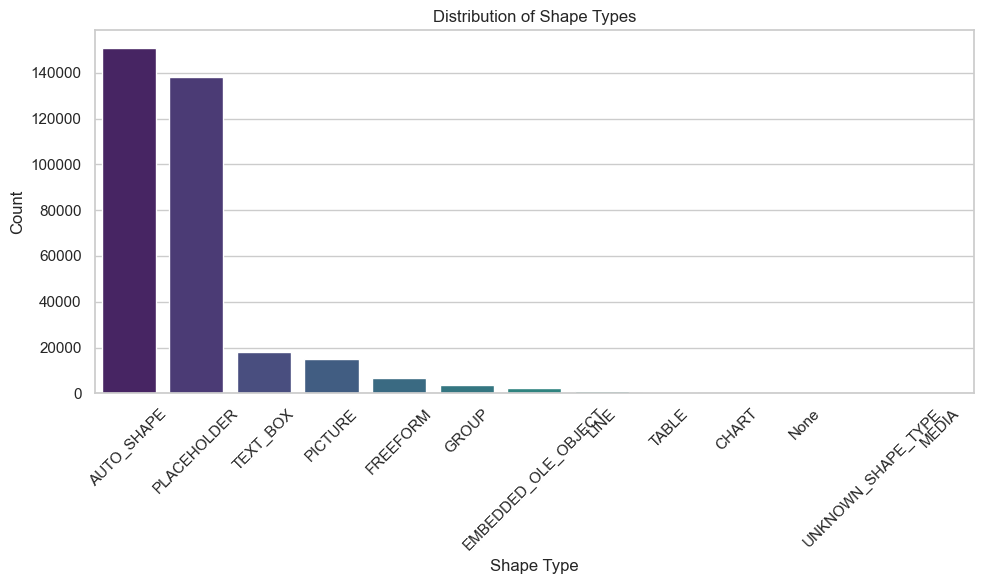

Plotting Number of Shapes per Slide...


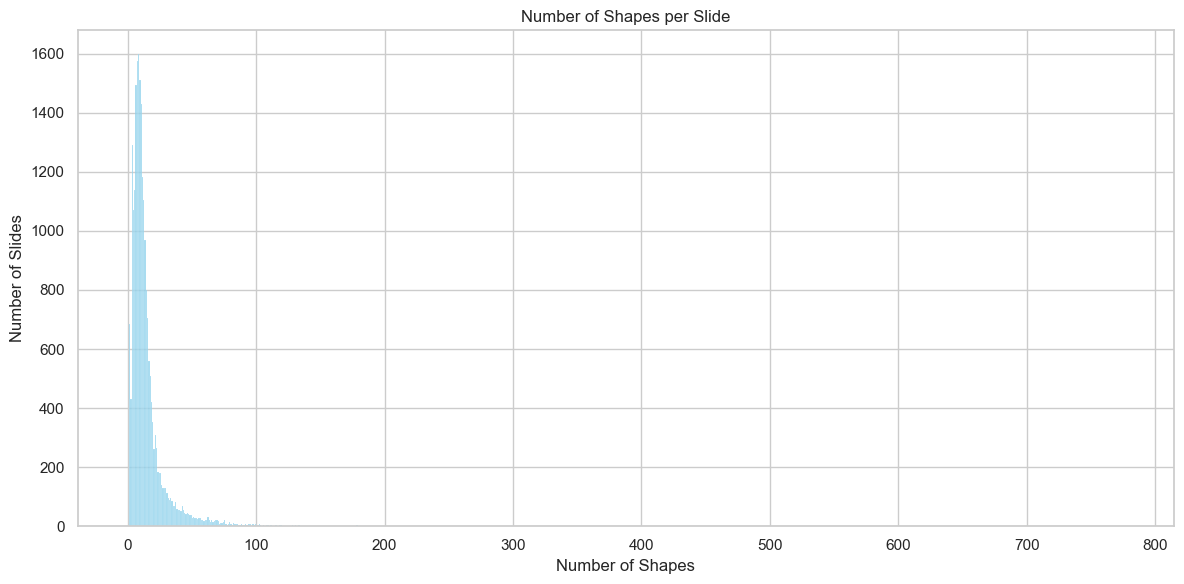

Plotting Shapes by Slide Number...


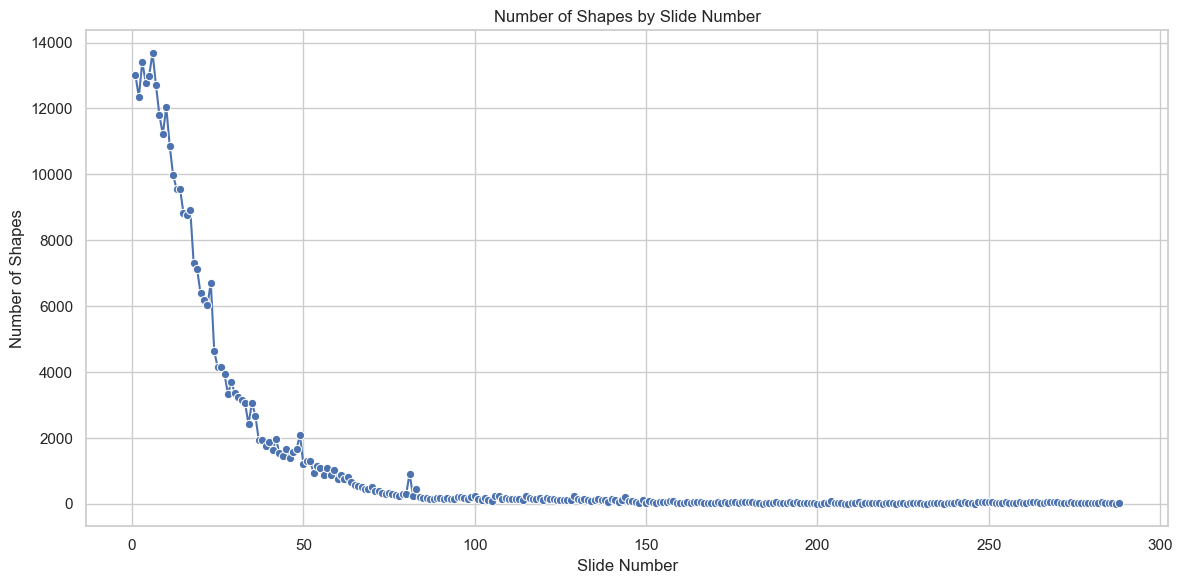

Plotting Shape Size Distribution...


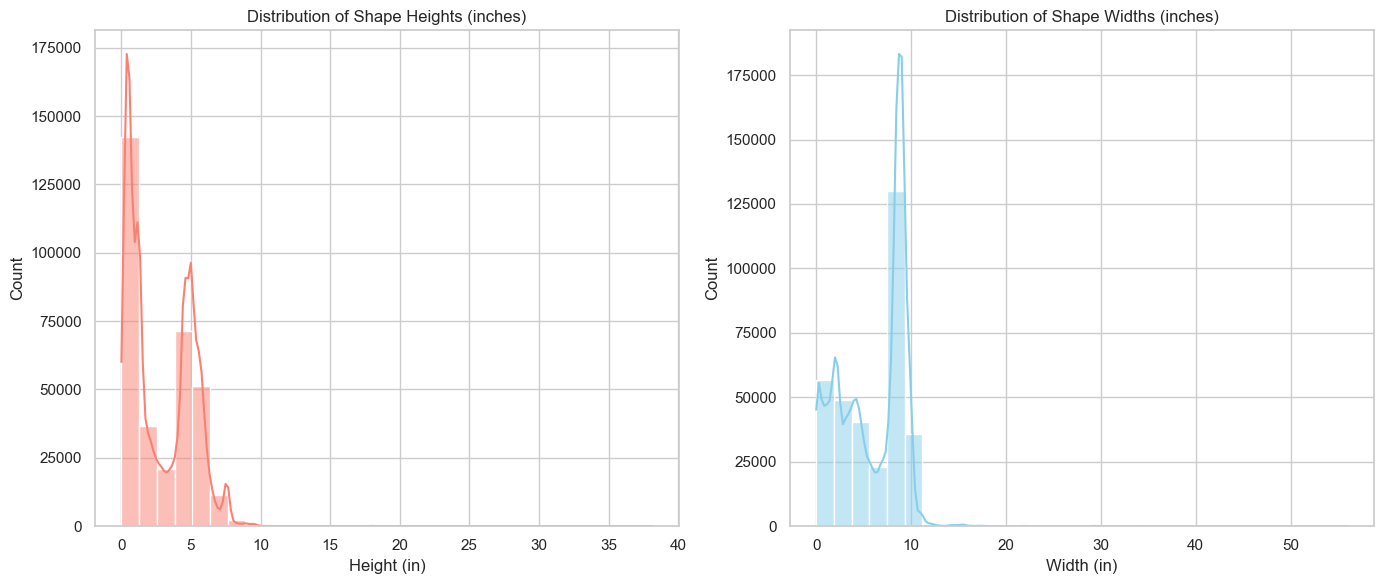

Plotting Font Size Distribution...


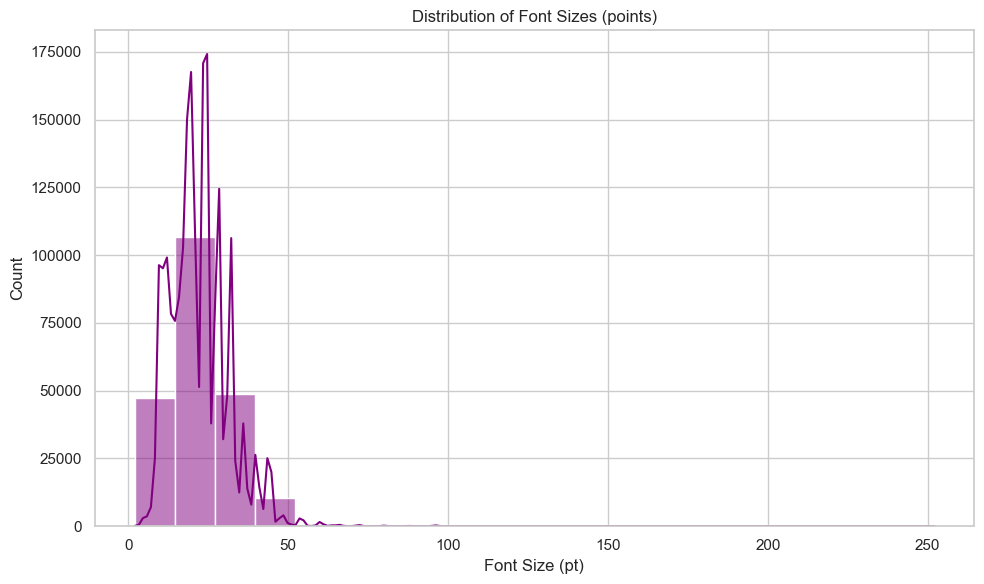

In [11]:
def main():
    # Specify the directory containing JSON files
    json_directory = "/Users/tyrionhuu/projects/research_projects/PPTBench/dataset/json"  # Replace with your directory path

    # Step 1: Read JSON files
    print("Reading JSON files...")
    json_data = read_json_files(json_directory)
    if not json_data:
        print("No JSON data found. Exiting.")
        return

    # Step 2: Aggregate data into DataFrames
    print("Aggregating data...")
    slides_df, shapes_df = aggregate_data(json_data)

    print(f"Total Presentations: {slides_df['presentation_id'].nunique()}")
    print(f"Total Slides: {slides_df.shape[0]}")
    print(f"Total Shapes: {shapes_df.shape[0]}")

    # Step 3: Perform Analysis and Visualization

    # 1. Shape Types Distribution
    print("Plotting Shape Types Distribution...")
    plot_shape_types_distribution(shapes_df)

    # 2. Number of Shapes per Slide
    print("Plotting Number of Shapes per Slide...")
    plot_shapes_per_slide(shapes_df)

    # 3. Distribution of Shapes by Slide Number
    print("Plotting Shapes by Slide Number...")
    plot_shapes_by_slide_number(shapes_df)

    # 4. Shape Size Distribution
    print("Plotting Shape Size Distribution...")
    plot_shape_size_distribution(shapes_df)

    # 5. Font Size Distribution
    print("Plotting Font Size Distribution...")
    plot_font_size_distribution(shapes_df)

    # Additional analyses can be added here

if __name__ == "__main__":
    main()
